In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Normal

import random

import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import celluloid
import seaborn as sns

save = True

In [2]:
dir_path1 = "results/intensity/entklerg_01/"
# Load Pickled Data
file_path1 = dir_path1 + "data_eval_dict.pickle"
with open(file_path1, 'rb') as f: 
    data_dict1 = pickle.load(f, encoding="bytes")
    print(data_dict1.keys())
obj1 = data_dict1['obj_loc']
obj2 = data_dict1['obj2_loc']
traj1 = data_dict1['path']
loss1 = data_dict1['losses']
buffer1 = data_dict1['buffer']
action1 = data_dict1['actions']
env_traj1 = data_dict1['env_path']
env_lim = data_dict1['tray_lim']
klerg_lim = data_dict1['klerg_lim']


dir_path2 = "results/intensity/rand_01/"
# Load Pickled Data
file_path2 = dir_path2 + "data_eval_dict.pickle"
with open(file_path2, 'rb') as f: 
    data_dict2 = pickle.load(f, encoding="bytes")
    print(data_dict2.keys())
# obj1 = data_dict2['obj_loc']
# obj2 = data_dict2['obj2_loc']
traj2 = data_dict2['path']
loss2 = data_dict2['losses']
buffer2 = data_dict2['buffer']
action2 = data_dict2['actions']
env_traj2 = data_dict2['env_path']
# env_lim = data_dict2['tray_lim']
# klerg_lim = data_dict2['klerg_lim']

dict_keys(['path', 'actions', 'buffer', 'env_path', 'obj_loc', 'obj2_loc', 'losses', 'tray_lim', 'klerg_lim'])
dict_keys(['path', 'actions', 'buffer', 'env_path', 'obj_loc', 'obj2_loc', 'losses', 'tray_lim', 'klerg_lim'])


In [3]:
from franka.franka_utils import *

# Load Pytorch Models
# model1 = torch.load("model_int_check.pth")
model1 = torch.load(dir_path1 + "model_final_postlearning.pth")
model1.eval()


# Load Pytorch Models
# model2 = torch.load("model_int_check.pth")
model2 = torch.load(dir_path2 + "model_final_postlearning.pth")
model2.eval()

/home/enrique/.local/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/enrique/.local/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/enrique/.local/lib/python3.6/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the o

VAE(
  (encode): Sequential(
    (0): Linear(in_features=1446, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=32, bias=True)
  )
  (decode): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1445, bias=True)
  )
)

In [4]:
# Load test data

dir_path = "results/intensity/test_data/"
# Load Pickled Data
file_path = dir_path + "data_eval_dict.pickle"
with open(file_path, 'rb') as f: 
    data_dict = pickle.load(f, encoding="bytes")
    print(data_dict.keys())
testobj1 = data_dict['obj_loc']
testobj2 = data_dict['obj2_loc']
testtraj = data_dict['path']
testbuffer = data_dict['buffer']
test_env_traj = data_dict['env_path']
test_env_lim = data_dict['tray_lim']
test_klerg_lim = data_dict['klerg_lim']
print(testobj1, testobj2)

dict_keys(['path', 'buffer', 'env_path', 'obj_loc', 'obj2_loc', 'tray_lim', 'klerg_lim'])
(-0.1, -0.1, -0.4) (0.1, -0.1, -0.6)


In [5]:
ycheck1 = [None]*len(testbuffer)
ycheck2 = [None]*len(testbuffer)

with torch.no_grad():
    xt = np.expand_dims(testbuffer[0][0], axis=0)
    yt = np.expand_dims(np.mean(testbuffer[0][1][:,::2,::2],axis=0).flatten(), axis=0)

    xt = torch.FloatTensor(xt)#.squeeze()
    yt = torch.FloatTensor(yt)#.squeeze()
    print(xt.shape, yt.shape)
    _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
    z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

    _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
    z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

    ind = 0
    for i in range(int(len(testbuffer)/2)):
        
        xc = np.expand_dims(testbuffer[ind][0], axis=0)
        xc = torch.FloatTensor(xc)#.squeeze()

        y_pred = model1.decode(torch.cat([z_samples1, xc], dim=1))
        img_pred1 = y_pred[:,1:]
        ycheck1[ind] = img_pred1[0].detach().numpy().reshape((38,38)).T

        y_pred = model2.decode(torch.cat([z_samples2, xc], dim=1))
        img_pred2 = y_pred[:,1:]
        ycheck2[ind] = img_pred2[0].detach().numpy().reshape((38,38)).T
        
        ind +=1
        
    print(ind)
    xt = np.expand_dims(testbuffer[ind][0], axis=0)
    yt = np.expand_dims(np.mean(testbuffer[ind][1][:,::2,::2],axis=0).flatten(), axis=0)

    xt = torch.FloatTensor(xt)#.squeeze()
    yt = torch.FloatTensor(yt)#.squeeze()

    _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
    z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

    _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
    z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

    for i in range(int(len(testbuffer)/2)):
        xc = np.expand_dims(testbuffer[ind][0], axis=0)
        xc = torch.FloatTensor(xc)#.squeeze()

        y_pred = model1.decode(torch.cat([z_samples1, xc], dim=1))
        img_pred1 = y_pred[:,1:]
        ycheck1[ind] = img_pred1[0].detach().numpy().reshape((38,38)).T
        
        y_pred = model2.decode(torch.cat([z_samples2, xc], dim=1))
        img_pred2 = y_pred[:,1:]
        ycheck2[ind] = img_pred2[0].detach().numpy().reshape((38,38)).T
        
        ind += 1
print(ind)

torch.Size([1, 2]) torch.Size([1, 1444])
9
18


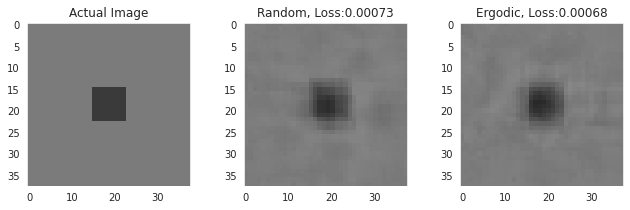

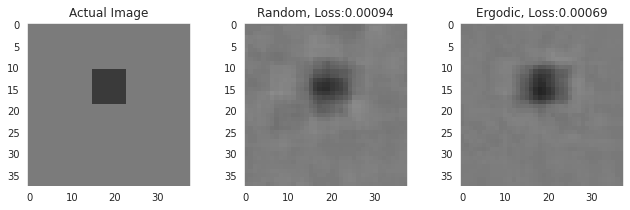

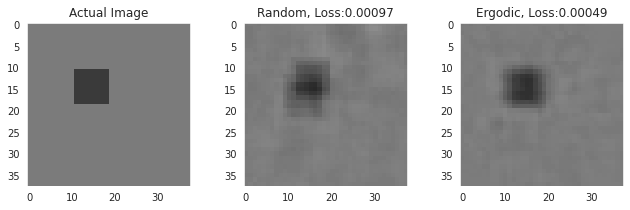

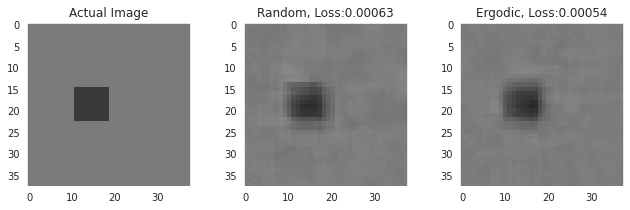

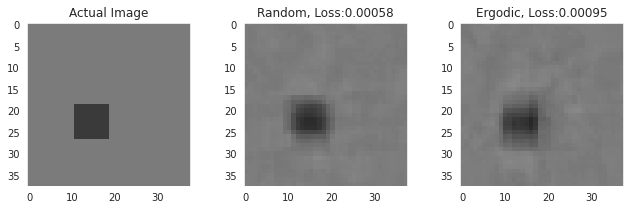

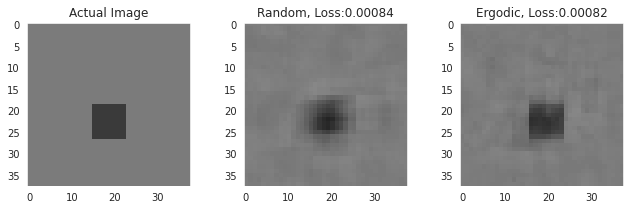

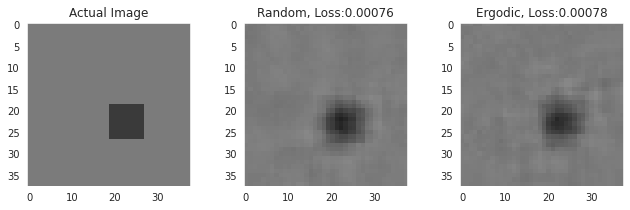

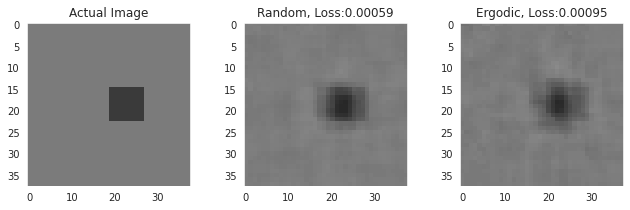

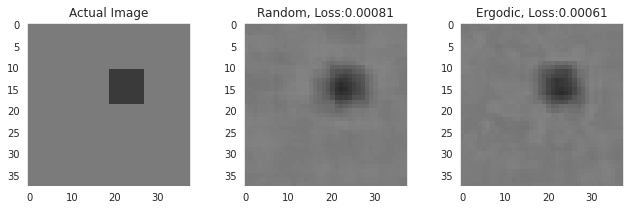

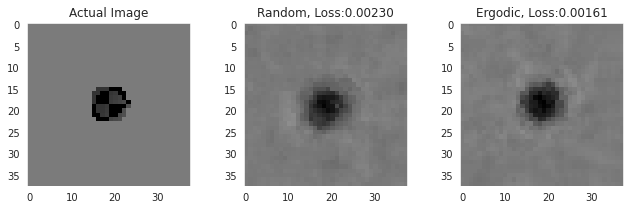

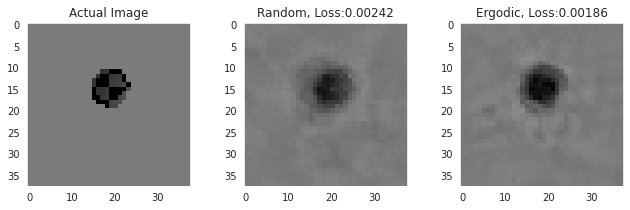

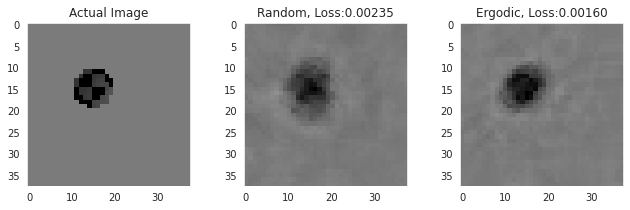

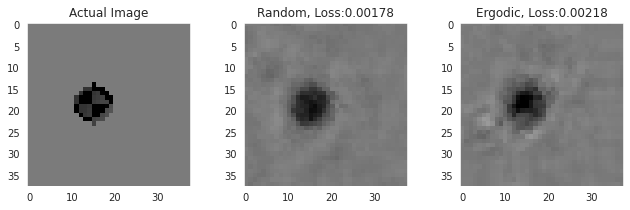

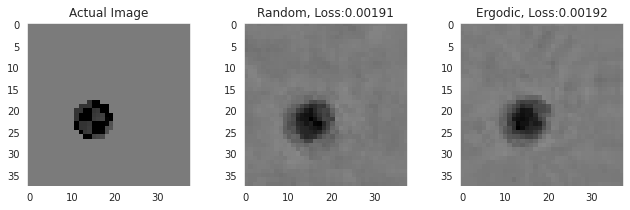

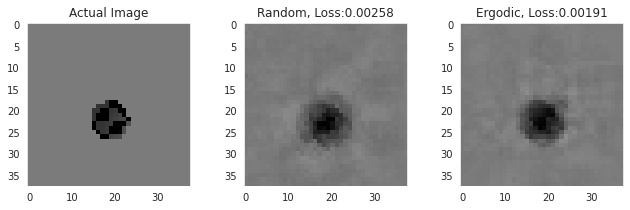

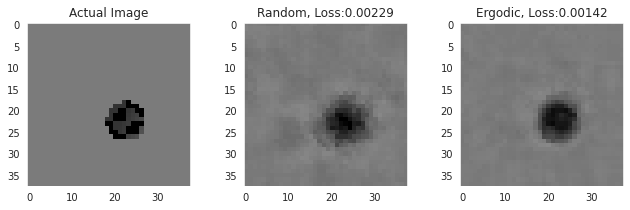

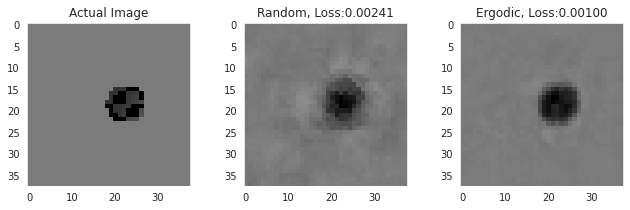

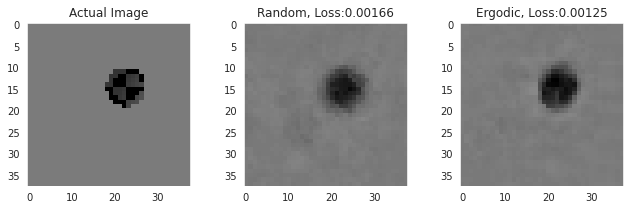

In [6]:
def mseloss(A,B): return np.square(np.subtract(A, B)).mean()

sns.set_style("dark")
for i in range(len(testbuffer)):
    fig, axes = plt.subplots(1,3, figsize=(11, 3))
    axes[0].imshow(np.mean(testbuffer[i][1][:,::2,::2],axis=0).T, cmap='gray',vmin=0, vmax=1)
    axes[0].set_title('Actual Image')
    axes[1].imshow((ycheck2[i]), cmap='gray',vmin=0, vmax=1)
    axes[1].set_title("Random, Loss:{:.5f}".format(mseloss(ycheck2[i], np.mean(testbuffer[i][1][:,::2,::2],axis=0).T)))
    axes[2].imshow((ycheck1[i]), cmap='gray',vmin=0, vmax=1)
    axes[2].set_title("Ergodic, Loss:{:.5f}".format(mseloss(ycheck1[i], np.mean(testbuffer[i][1][:,::2,::2],axis=0).T)))
    if save: plt.savefig("figures/intensity/"+str(i)+"_img_comp.pdf")
 

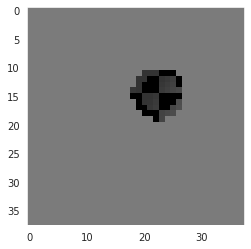

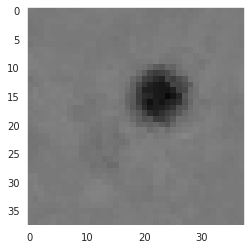

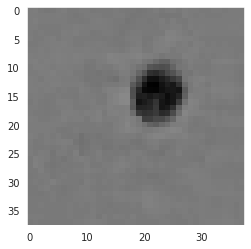

In [10]:
from IPython.display import clear_output

for i in range(int(len(testbuffer)/2)):
    clear_output(wait=True)
    plt.imshow(np.mean(testbuffer[i][1][:,::2,::2],axis=0).T, cmap='gray',vmin=0, vmax=1)
    if save: plt.savefig("figures/intensity/gifdata/"+str("{:02d}".format(i))+"_actual.png")
    plt.show()
    plt.imshow((ycheck2[i]), cmap='gray',vmin=0, vmax=1)
    if save: plt.savefig("figures/intensity/gifdata/"+str("{:02d}".format(i))+"_rand_est.png")
    plt.show()
    plt.imshow((ycheck1[i]), cmap='gray',vmin=0, vmax=1)
    if save: plt.savefig("figures/intensity/gifdata/"+str("{:02d}".format(i))+"_ent_est.png")
    plt.show()

for i in range(9,len(testbuffer)):
    clear_output(wait=True)
    plt.imshow(np.mean(testbuffer[i][1][:,::2,::2],axis=0).T, cmap='gray',vmin=0, vmax=1)
    if save: plt.savefig("figures/intensity/gifdata/"+str("{:02d}".format(i))+"_actual.png")
    plt.show()
    plt.imshow((ycheck2[i]), cmap='gray',vmin=0, vmax=1)
    if save: plt.savefig("figures/intensity/gifdata/"+str("{:02d}".format(i))+"_rand_est.png")
    plt.show()
    plt.imshow((ycheck1[i]), cmap='gray',vmin=0, vmax=1)
    if save: plt.savefig("figures/intensity/gifdata/"+str("{:02d}".format(i))+"_ent_est.png")
    plt.show()


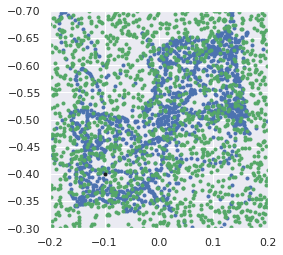

In [11]:
test_env_traj = np.array(test_env_traj)
sns.set(style='darkgrid')
# Plot Traj
fig = plt.figure()
fig.patch.set_facecolor('white')
env_traj1 = np.array(env_traj1)
plt.plot(env_traj1[:,0], env_traj1[:,2],'b.')
plt.plot(env_traj2[:,0], env_traj2[:,2],'g.')

plt.plot(obj1[0], obj1[2],'k.')
plt.plot(obj2[0], obj2[2],'g.')
# plt.plot(test_env_traj[:,0], test_env_traj[:,2], 'r.')
plt.axis('square')
plt.xlim(env_lim[0])
plt.ylim(env_lim[1])
plt.show()

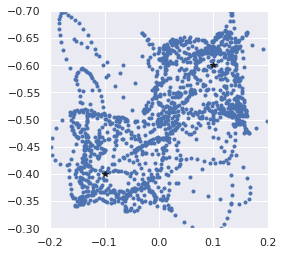

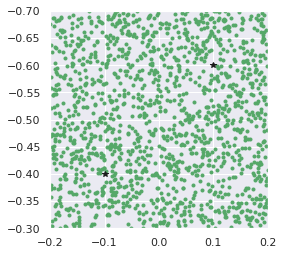

In [12]:
fig = plt.figure()
fig.patch.set_facecolor('white')
env_traj1 = np.array(env_traj1)
plt.plot(env_traj1[:,0], env_traj1[:,2],'b.')

# plt.plot(np.array(test_env_traj)[:,0], np.array(test_env_traj)[:,2], 'r.')
plt.plot(obj1[0], obj1[2],'k*')
plt.plot(obj2[0], obj2[2],'k*')
plt.axis('square')
plt.xlim(env_lim[0])
plt.ylim(env_lim[1])
if save: plt.savefig('figures/intensity/entropy_traj.pdf')#_wtestdata.pdf')
plt.show()

fig = plt.figure()
fig.patch.set_facecolor('white')
env_traj1 = np.array(env_traj1)
plt.plot(env_traj2[:,0], env_traj2[:,2],'g.')

# plt.plot(np.array(test_env_traj)[:,0], np.array(test_env_traj)[:,2], 'r.')
plt.plot(obj1[0], obj1[2],'k*')
plt.plot(obj2[0], obj2[2],'k*')

plt.axis('square')
plt.xlim(env_lim[0])
plt.ylim(env_lim[1])
if save: plt.savefig('figures/intensity/random_traj.pdf')#_wtestdata.pdf')
plt.show()

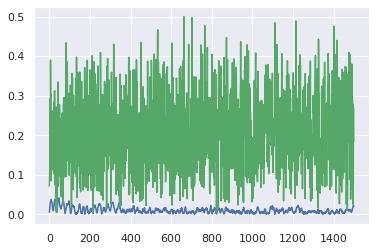

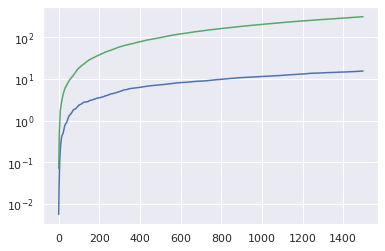

In [13]:
energy1 = [np.linalg.norm(env_traj1[i+1]-env_traj1[i]) for i in range(len(env_traj1)-1)]
plt.plot(energy1,'b')
energy2 = [np.linalg.norm(env_traj2[i+1]-env_traj2[i]) for i in range(len(env_traj2)-1)]
plt.plot(energy2,'g')
# plt.plot(np.linalg.norm(action2, axis=1))
if save: plt.savefig('figures/intensity/logenergy_vs_time.pdf')
plt.show()
plt.semilogy(np.cumsum(energy1),'b')
plt.semilogy(np.cumsum(energy2),'g')
if save: plt.savefig('figures/intensity/logcumenergy_vs_time.pdf')



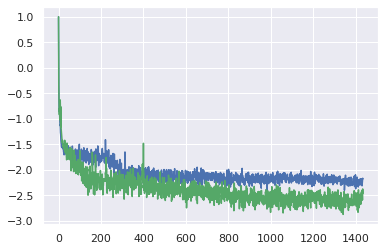

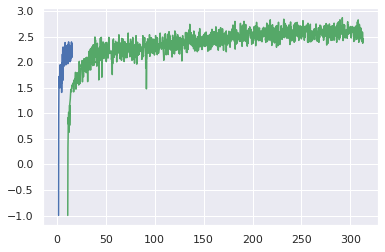

In [14]:
plt.plot(loss1[::10], 'b')
plt.plot(loss2[::10], 'g')
plt.show()

plt.plot(np.cumsum(energy1)[64:],-np.array(loss1[::10]), 'b')
plt.plot(np.cumsum(energy2)[64:],-np.array(loss2[::10]), 'g')
plt.show()


In [15]:
loss1 = []
loss2 = []
mseloss1 = [None]*len(testbuffer)
mseloss2 = [None]*len(testbuffer)

with torch.no_grad():
    for cp in range(50,15400,50):
        PATH =  dir_path1 + "model_checkpoint_iter"+str(cp)+".pth"
        model1.load_state_dict(torch.load(PATH)['state_dict'])
        model1.eval()

        PATH =  dir_path2 + "model_checkpoint_iter"+str(cp)+".pth"
        model2.load_state_dict(torch.load(PATH)['state_dict'])
        model2.eval()

        xt = np.expand_dims(testbuffer[0][0], axis=0)
        yt = np.expand_dims(np.mean(testbuffer[0][1][:,::2,::2],axis=0).flatten(), axis=0)

        xt = torch.FloatTensor(xt)#.squeeze()
        yt = torch.FloatTensor(yt)#.squeeze()
        _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
        z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

        _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
        z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

        ind = 0
        for i in range(int(len(testbuffer)/2)):

            xc = np.expand_dims(testbuffer[ind][0], axis=0)
            xc = torch.FloatTensor(xc)#.squeeze()

            y_pred = model1.decode(torch.cat([z_samples1, xc], dim=1))
            img_pred1 = y_pred[:,1:]
            ycheck1 = img_pred1[0].detach().numpy().reshape((38,38)).T
            mseloss1[ind] = mseloss(ycheck1, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)


            y_pred = model2.decode(torch.cat([z_samples2, xc], dim=1))
            img_pred2 = y_pred[:,1:]
            ycheck2 = img_pred2[0].detach().numpy().reshape((38,38)).T
            mseloss2[ind] = mseloss(ycheck2, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)
            ind +=1

        xt = np.expand_dims(testbuffer[ind][0], axis=0)
        yt = np.expand_dims(np.mean(testbuffer[ind][1][:,::2,::2],axis=0).flatten(), axis=0)

        xt = torch.FloatTensor(xt)#.squeeze()
        yt = torch.FloatTensor(yt)#.squeeze()

        _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
        z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

        _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
        z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

        for i in range(int(len(testbuffer)/2)):
            xc = np.expand_dims(testbuffer[ind][0], axis=0)
            xc = torch.FloatTensor(xc)#.squeeze()

            y_pred = model1.decode(torch.cat([z_samples1, xc], dim=1))
            img_pred1 = y_pred[:,1:]
            ycheck1 = img_pred1[0].detach().numpy().reshape((38,38)).T
            mseloss1[ind] = mseloss(ycheck1, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)

            y_pred = model2.decode(torch.cat([z_samples2, xc], dim=1))
            img_pred2 = y_pred[:,1:]
            ycheck2 = img_pred2[0].detach().numpy().reshape((38,38)).T
            mseloss2[ind] = mseloss(ycheck2, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)
            ind += 1
        loss1.append(mseloss1.copy())
        loss2.append(mseloss2.copy())


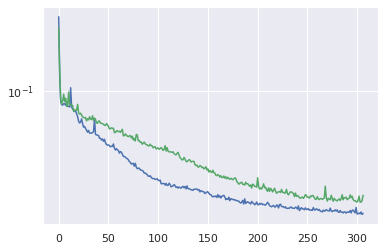

In [16]:
loss1 = np.array(loss1)
loss2 = np.array(loss2)

plt.semilogy(np.sum(loss1, axis=1), 'b')
plt.semilogy(np.sum(loss2, axis=1),'g')
if save: plt.savefig('figures/intensity/logtestinglossovertime.pdf')
plt.show()


